In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re,string
import os

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer , WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

STOPWORDS = set(stopwords.words('english'))
from wordcloud import WordCloud

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets


[nltk_data] Downloading package stopwords to C:\Users\Sahil
[nltk_data]     Rana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sahil
[nltk_data]     Rana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sahil Rana\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Sahil
[nltk_data]     Rana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sahil
[nltk_data]     Rana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Sahil
[nltk_data]     Rana\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-

In [2]:
data = pd.read_csv('twitter_training.csv',header=None)
print(data.shape)
data.head()

(74682, 4)


,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
#Rename the columns
data.columns = ['tweet_id','subject','sentiment','text']
data.head()

,tweet_id,subject,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
#check for null values
data.isnull().sum()

tweet_id       0
subject        0
sentiment      0
text         686
dtype: int64

In [5]:
data['text'].isna() == True
data.dropna(inplace=True)
print(f"Dataset shape after dropping null values: {data.shape}")

Dataset shape after dropping null values: (73996, 4)


Class distribution: 
 sentiment
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64


C:\Users\Sahil Rana\anaconda3\Lib\site-packages\seaborn\categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


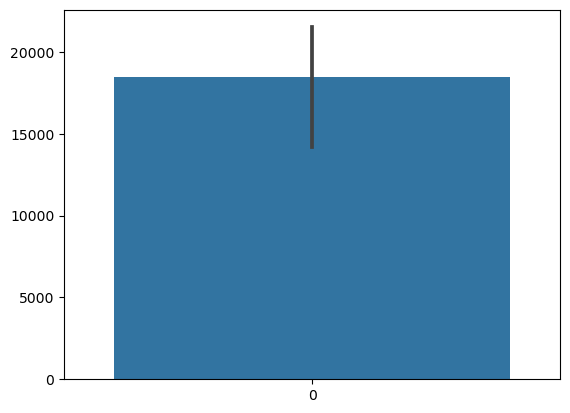

In [6]:
#Data Distribution
sentiment_counts = data['sentiment'].value_counts()
sns.barplot(sentiment_counts)
print("Class distribution: \n", sentiment_counts)

In [7]:
#Percentage distribution
print(f"Sentiment value count - percentage distribution : \n{round(data['sentiment'].value_counts()/data.shape[0]*100,2)}")

Sentiment value count - percentage distribution : 
sentiment
Negative      30.22
Positive      27.91
Neutral       24.47
Irrelevant    17.40
Name: count, dtype: float64


In [8]:
data['length'] = data['text'].apply(len)
data.head()

,tweet_id,subject,sentiment,text,length
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,53
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,51
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,50
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,51
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57


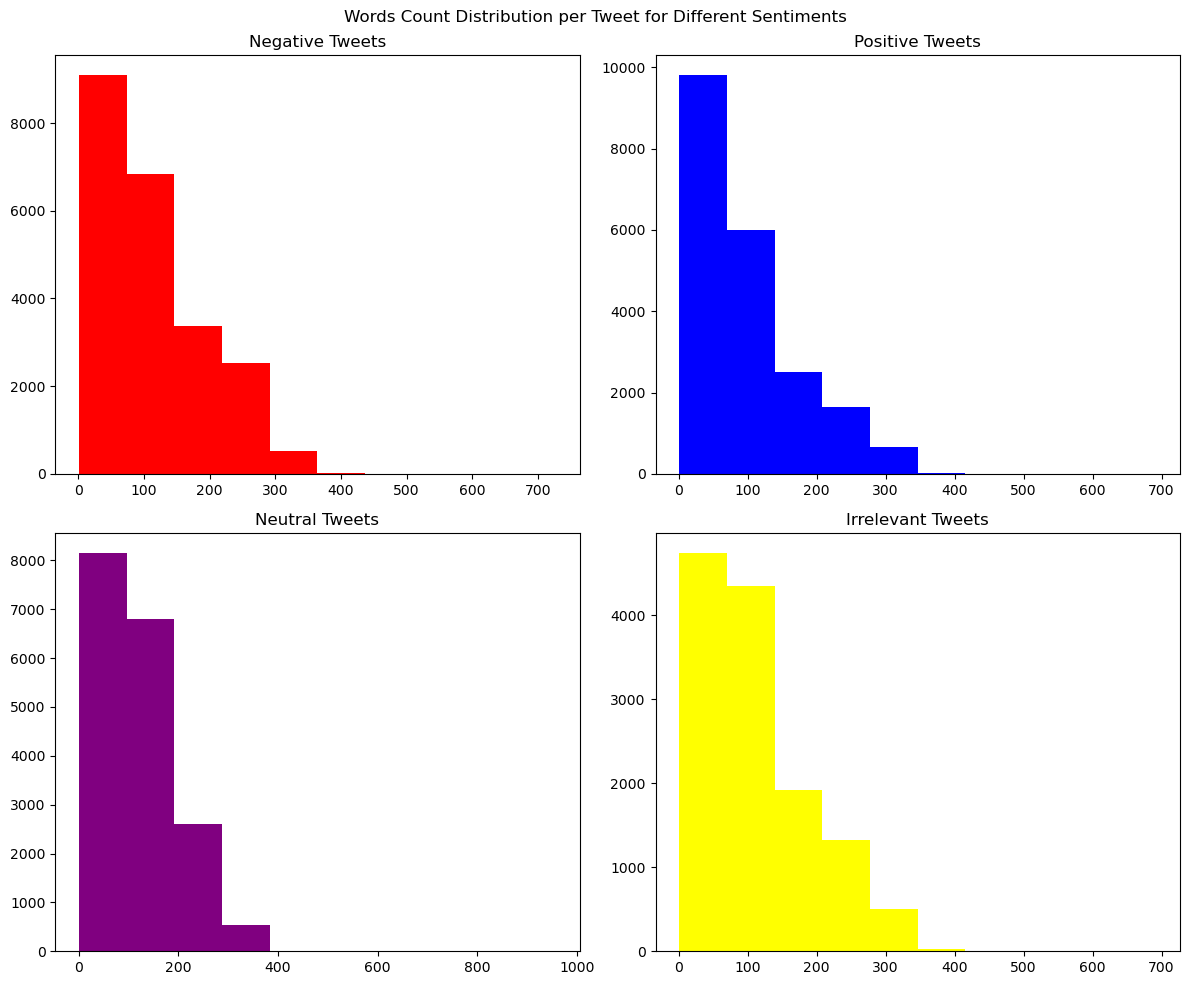

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Negative sentiment
train_words = data[data['sentiment'] == 'Negative']['length']
ax1.hist(train_words, color='red')
ax1.set_title('Negative Tweets')

# Positive sentiment
train_words = data[data['sentiment'] == 'Positive']['length']
ax2.hist(train_words, color='blue')
ax2.set_title('Positive Tweets')

# Neutral sentiment
train_words = data[data['sentiment'] == 'Neutral']['length']
ax3.hist(train_words, color='purple')
ax3.set_title('Neutral Tweets')

# Irrelevant sentiment
train_words = data[data['sentiment'] == 'Irrelevant']['length']
ax4.hist(train_words, color='yellow')  # Changed color to distinguish from green used for Positive
ax4.set_title('Irrelevant Tweets')

fig.suptitle('Words Count Distribution per Tweet for Different Sentiments')
plt.tight_layout()
plt.show()


In [24]:
#1. Common text preprocessing
text = "   This is a message to be cleaned. It may involve some things like: , ?, :, ''  adjacent spaces and tabs     .  "

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower().strip().capital().islower()-> print("small letter") #lowercase text
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace

    return text

text=preprocess(text)
print(text)  #text is a string


SyntaxError: invalid syntax (4164408229.py, line 6)

In [11]:
#LEXICON Based text processing

#1. STOPWORD removal
def stopword(string):
  return ' '.join([word for word in string.split() if word not in STOPWORDS])

text = stopword(text)
print(text)

#2. Stemming
#Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
  return ' '.join([snow.stem(word) for word in word_tokenize(string)])

text = stemming(text)
print(text)

#3 Lemmatization
#Initialise the Lemmatizer
wl = WordNetLemmatizer()

def get_wordnet_pos(tag):         #Get pos- maps NLTK pos to WordNets pos
  if tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('N'):
    return wordnet.NOUN
  elif tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

#tokenize the sentence
def lemmatizer(string):
  word_pos_tags = nltk.pos_tag(word_tokenize(string))
  a=[wl.lemmatize(tag[0],get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
  return " ".join(a)

text = lemmatizer(text)
print(text)

message cleaned may involve things like adjacent spaces tabs
messag clean may involv thing like adjac space tab
messag clean may involv thing like adjac space tab


In [12]:
#FINAL PREPROCESSING
def finalpreprocess(string):
  return lemmatizer(stopword(preprocess(string)))

#Applying final preprocessing
data['clean_text'] = data['text'].apply(lambda x: finalpreprocess(x))
data.head()

,tweet_id,subject,sentiment,text,length,clean_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,53,im get borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,51,come border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,50,im get borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,51,im come borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57,im get borderland murder


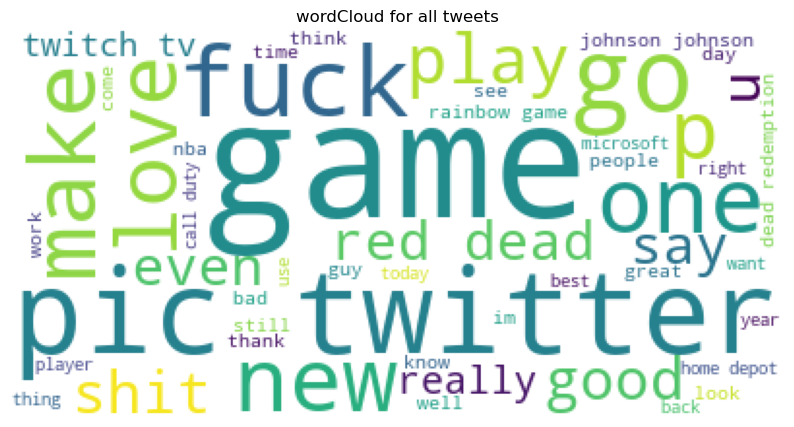

In [13]:
#using wordcloud
#combine all tweets

tweets = " ".join([tweet for tweet in data['clean_text']])
wc = WordCloud(background_color='white',max_words=50)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(tweets))
plt.title('wordCloud for all tweets')
plt.axis('off')
plt.show()

In [14]:
 # Combine all reviews for each feedback category and split them into individual words
neg_rev = set(" ".join([review for review in data[data['sentiment'] == 'Negative']['clean_text']]).lower().split())
pos_rev = set(" ".join([review for review in data[data['sentiment'] == 'Positive']['clean_text']]).lower().split())
neu_rev = set(" ".join([review for review in data[data['sentiment'] == 'Neutral']['clean_text']]).lower().split())
irr_rev = set(" ".join([review for review in data[data['sentiment'] == 'Irrelevant']['clean_text']]).lower().split())

# Find unique words for each category
uni_neg = " ".join(neg_rev - pos_rev - neu_rev - irr_rev)
uni_pos = " ".join(pos_rev - neg_rev - neu_rev - irr_rev)
uni_neu = " ".join(neu_rev - neg_rev - pos_rev - irr_rev)
uni_irr = " ".join(irr_rev - neg_rev - pos_rev - neu_rev)

print("Unique Negative Words:", uni_neg)
print("Unique Positive Words:", uni_pos)
print("Unique Neutral Words:", uni_neu)
print("Unique Irrelevant Words:", uni_irr)


Unique Negative Words: yekkefiymeo dayway unarmed separated childern играй nk shabby nightmarebec rachet playststion coerce arguing laredo overpay trendingscroll pozdravlyaetsя bpaupg aventurastistoria errand deliverer tack herz toka dsr backstab myy trojan indianews beef retract glide dypbknexz ubisoftcanada gfzg typescript passa lhtmmhlrtr vaginal hawkins dafuq scotus tens birx southgate fqvq disturbed unjust majorseven uyn robodanjal rsluzev armys optation lumber precipitation bunker arbitration vhxmwe ethicon vjiq nuts unskippable href ltreasures manna apexlegends maxi appointment golftv irritating dbtjpnt nutmegging dramatic aspynovard buts cunningham ubisupportde jkn battler wtfff vp bruhns dindt fábregas trample incognito velkoz lrt exceedingly jopping broseph rivfcw ralls cpwdrmuedg unprofessional scoob invert whyyc underwhelming roaring armello qbzoh ownership etqubdqvu zac yknz cityofgilroy biizawz diligence prerecord screwed sbhd plugins doe persecute dropped giive supplying

In [15]:
# create Word2vec model
data['clean_text_tok']=[nltk.word_tokenize(i) for i in data['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(data['clean_text_tok'],min_count=1)

w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) #combination of word and its vector

#for converting text data to numerical vectors using pre-trained word vectors from Word2Vec.
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec              #store pretrained Word2Vec model
        self.dim = len(next(iter(word2vec.values())))       #to ensure all vecores have same dimensionality
# if a text is empty we should return a vector of zeros
# with the same dimensionality as all the other vectors

    def fit(self, X, y):                      #Standardization- allows the MeanEmbeddingVectorizer to be used in the same way as other scikit-learn transformers.
        return self

    def transform(self, X):                   #Converts a list of tokenized texts into numerical vectors
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [16]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION

X_train, X_val, y_train, y_val = train_test_split(data["clean_text"],
                                                  data['sentiment'],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector - Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your val data: it will
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the val data, to reflect the fact you're analyzing the val data only based on what model has learned.


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [17]:

# Logistic Regression (TF-IDF)
lr_tfidf = LogisticRegression(solver='liblinear', C=10, penalty='l2', multi_class='ovr')  # Ensure multi-class is specified
lr_tfidf.fit(X_train_vectors_tfidf, y_train)
pred_lr_tfidf = lr_tfidf.predict(X_val_vectors_tfidf)

# Accuracy
print('accuracy %s' % accuracy_score(pred_lr_tfidf, y_val))
print(classification_report(y_val, pred_lr_tfidf))

# Compute ROC AUC score for multi-class classification
y_val_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)
roc_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr')
print('ROC AUC Score:', roc_auc)

#Confusion Matrix
print('Confusion Matrix: ', confusion_matrix(y_val, pred_lr_tfidf))


accuracy 0.842027027027027
              precision    recall  f1-score   support

  Irrelevant       0.86      0.79      0.83      2505
    Negative       0.84      0.88      0.86      4484
     Neutral       0.89      0.81      0.85      3630
    Positive       0.80      0.86      0.83      4181

    accuracy                           0.84     14800
   macro avg       0.85      0.84      0.84     14800
weighted avg       0.84      0.84      0.84     14800

ROC AUC Score: 0.9641936987176528
Confusion Matrix:  [[1985  182   83  255]
 [  85 3927  133  339]
 [  97  262 2940  331]
 [ 133  279  159 3610]]


In [18]:
# Function to preprocess the data
def finalpreprocess(text):
    # Add your preprocessing steps here
    return text

# Read the data
val_data = pd.read_csv('twitter_validation.csv')
val_data.columns = ['tweet_id', 'subject', 'sentiment', 'text']

# Preprocess the data
val_data['clean_text'] = val_data['text'].apply(lambda x: finalpreprocess(x))
X_test = val_data['clean_text']
X_vector = tfidf_vectorizer.transform(X_test)  # Convert X_test to vector

# Use the trained model on X_vector
y_predict = lr_tfidf.predict(X_vector)
y_prob = lr_tfidf.predict_proba(X_vector)[:, 1]

# Add predictions to the DataFrame
val_data['predict_prob'] = y_prob
val_data['sentiment'] = y_predict

print(val_data.head())

# Prepare final submission
final = val_data[['tweet_id', 'sentiment', 'text']].reset_index(drop=True)

# Get the file name from the user
output_file = input("Enter the output file name (with .csv extension): ")

# Define the directory where you want to save the file
output_directory = os.path.dirname(output_file)
if not output_directory:
    output_directory = '.'  # Save in the current directory if no path is provided

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Write to CSV
try:
    final.to_csv(output_file, index=False)
    print(f"File written successfully to {output_file}")
except PermissionError as e:
    print(f"PermissionError: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


   tweet_id    subject sentiment  \
0       352     Amazon   Neutral   
1      8312  Microsoft  Negative   
2      4371      CS-GO  Negative   
3      4433     Google   Neutral   
4      6273       FIFA  Negative   

                                                text  \
0  BBC News - Amazon boss Jeff Bezos rejects clai...   
1  @Microsoft Why do I pay for WORD when it funct...   
2  CSGO matchmaking is so full of closet hacking,...   
3  Now the President is slapping Americans in the...   
4  Hi @EAHelp I’ve had Madeleine McCann in my cel...   

                                          clean_text  predict_prob  
0  BBC News - Amazon boss Jeff Bezos rejects clai...      0.131926  
1  @Microsoft Why do I pay for WORD when it funct...      0.911965  
2  CSGO matchmaking is so full of closet hacking,...      0.956534  
3  Now the President is slapping Americans in the...      0.004638  
4  Hi @EAHelp I’ve had Madeleine McCann in my cel...      0.925159  
Enter the output file name (with